<h1><center>Home Credit Risk Prediction</center></h1>
<center> - sections 5/6 - </center>
<center>December 2024</center>
<center>Celine Ng</center>

# Table of Contents

1. Project Introduction
    1. Notebook Preparation
    1. Data loading
1. Main Data Preparation
    1. Data cleaning
    1. Dataframes and keys
    1. Train Test Split
    1. Quick EDA
        1. Keys present in each table
        1. Distribution
    1. Aggregation
1. Initial Data Cleaning
    1. Datatypes
    1. Missing values
1. EDA
    1. Original Application Table Distribution
    1. Correlation
    1. Statistical Inference
1. Data Preprocessing
1. Feature Engineering
    1. Baseline Model
    1. New Features
    1. More new features
1. Models
    1. Pipeline
    1. Model Selection
    1. Test Data
1. Final Model
    1. Final Model
    1. Deployment
    1. Model Interpretation
1. Improvements

In [1]:
%%capture
%pip install -r requirements.txt

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import pickle as pkl
import os

from utils.eda import *
from utils.stats import *
from utils.custom_preprocessor import *
from utils.model import *

from sklearn.compose import make_column_selector as selector
from sklearn.preprocessing import (OrdinalEncoder, FunctionTransformer)
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.metrics import classification_report, roc_auc_score
from sklearn.model_selection import cross_val_score, StratifiedKFold

import xgboost as xgb
import optuna
from scipy.sparse import csr_matrix
import shap

/Users/celineng/PycharmProjects/chilng-DS.v2.5.3.4.1/.venv/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


***

# Variables & Data from previous Notebooks

Load aggregated main table

In [3]:
project_root = os.path.abspath(os.path.join(os.getcwd(), ".."))
folder = os.path.join(project_root, "aggregated_data")
data_path = os.path.join(folder, "data_merged.pkl")
data = pd.read_pickle(data_path)

Define variables

In [4]:
target = 'TARGET'
binary_columns =['FLAG_MOBIL', 'FLAG_EMP_PHONE', 'FLAG_WORK_PHONE',
                 'FLAG_CONT_MOBILE', 'FLAG_PHONE', 'FLAG_EMAIL', 'REG_REGION_NOT_LIVE_REGION', 'REG_REGION_NOT_WORK_REGION', 'LIVE_REGION_NOT_WORK_REGION', 'REG_CITY_NOT_LIVE_CITY', 'REG_CITY_NOT_WORK_CITY', 'LIVE_CITY_NOT_WORK_CITY', 'FLAG_DOCUMENT_2', 'FLAG_DOCUMENT_3', 'FLAG_DOCUMENT_4', 'FLAG_DOCUMENT_5', 'FLAG_DOCUMENT_6', 'FLAG_DOCUMENT_7', 'FLAG_DOCUMENT_8', 'FLAG_DOCUMENT_9', 'FLAG_DOCUMENT_10', 'FLAG_DOCUMENT_11', 'FLAG_DOCUMENT_12', 'FLAG_DOCUMENT_13', 'FLAG_DOCUMENT_14', 'FLAG_DOCUMENT_15', 'FLAG_DOCUMENT_16', 'FLAG_DOCUMENT_17', 'FLAG_DOCUMENT_18', 'FLAG_DOCUMENT_19', 'FLAG_DOCUMENT_20', 'FLAG_DOCUMENT_21', 'EMERGENCYSTATE_MODE', 'FLAG_OWN_CAR', 'FLAG_OWN_REALTY', 'CODE_GENDER']
categorical_columns = ['NAME_CONTRACT_TYPE', 'NAME_TYPE_SUITE', 'NAME_INCOME_TYPE', 'NAME_EDUCATION_TYPE', 'NAME_FAMILY_STATUS', 'NAME_HOUSING_TYPE', 'OCCUPATION_TYPE', 'WEEKDAY_APPR_PROCESS_START', 'ORGANIZATION_TYPE', 'FONDKAPREMONT_MODE', 'HOUSETYPE_MODE', 'WALLSMATERIAL_MODE']

***

# 5. Data Preprocessing

Separate data and target. Sample half of X and y for faster tuning

In [5]:
ml_data = data.copy()
ml_data_sample = ml_data.sample(n=10, random_state=42)

X, y = (ml_data.drop(columns=[target]).copy(),
        ml_data[target].reset_index(drop=True))

X_sample, _, y_sample, _ = train_test_split(
    X, y, train_size=0.5, random_state=42, stratify=y
)

**Define columns**

In [6]:
numerical_binary_columns = (ml_data_sample[binary_columns].select_dtypes
                            (include='number'))
object_binary_columns = [col for col in binary_columns if col not in numerical_binary_columns]

**Define Preprocessors**

In [7]:
preprocessor_encode = ColumnTransformer(
    transformers=[
        ('binary_encode', OrdinalEncoder(), object_binary_columns),
        ('freq_encode', FrequencyEncoder(), categorical_columns),
    ],
    remainder='passthrough',
    verbose_feature_names_out=False
)

Pipeline for now, as other steps are completed without pipeline already

In [8]:
preprocessing_pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor_encode)
])

# 6. Feature Engineering
Objective: Check baseline model (before new features), and compare to model
after new features

## 6.1. Baseline model
Without new features (BUREAU_ID, PREV_ID, etc.)

Split data set into train and validation, as test
is already prepared.

In [9]:
X_train, X_eval, y_train, y_eval = train_test_split(
    X_sample, y_sample, test_size=0.2, random_state=0, stratify=y_sample
)

X_train_tf = pd.DataFrame(
    preprocessor_encode.fit_transform(X_train, y_train),
    columns=preprocessor_encode.get_feature_names_out(),
)
X_eval_tf = pd.DataFrame(
    preprocessor_encode.transform(X_eval), columns=preprocessor_encode.get_feature_names_out()
)

In [10]:
num_negative = (y_train == 0).sum()
num_positive = (y_train == 1).sum()

scale_pos_weight = num_negative / num_positive

clf_xgb = xgb.XGBClassifier(objective='binary:logistic', random_state=42,
                            scale_pos_weight=scale_pos_weight)

clf_xgb.fit(
    X_train_tf, y_train,
    eval_set=[(X_eval_tf, y_eval)],
    verbose=False
)

y_pred = clf_xgb.predict(X_eval_tf)
y_prob = clf_xgb.predict_proba(X_eval_tf)[:, 1]

evaluation_metrics = {
    'accuracy': accuracy_score(y_eval, y_pred),
    'roc_auc': roc_auc_score(y_eval, y_prob),
    'precision': precision_score(y_eval, y_pred, zero_division=0),
    'recall': recall_score(y_eval, y_pred, zero_division=0),
    'f1': f1_score(y_eval, y_pred, zero_division=0)
}

evaluation_df = pd.DataFrame(evaluation_metrics, index=['Evaluation'])
evaluation_df

,accuracy,roc_auc,precision,recall,f1
Evaluation,0.810617,0.73299,0.208379,0.480866,0.29076


**Cross Validation and Early Stopping**<br>
*Primary Metric: ROC AUC*<br>
The dataset is imbalanced and so it would be important for the model to
distinguish between the 2 classes, default or not.
<br><br>
*Secondary Metric: F1 Score*<br>
Provides a balanced view of precision and recall, ensuring
that each class is handled reasonably well in terms of both capturing and
not over-predicting each class.

In [11]:
dtrain = xgb.DMatrix(X_train_tf, label=y_train)

params = {
    'objective': 'binary:logistic',
    'eval_metric': 'auc',
    'scale_pos_weight': (y_train == 0).sum() / (y_train == 1).sum(),
    'random_state': 42
}

cv_results = xgb.cv(
    params=params,
    dtrain=dtrain,
    num_boost_round=1000,
    nfold=5,
    early_stopping_rounds=10,
    verbose_eval=True,
    metrics='auc'
)

print(f"Best iteration: {cv_results.shape[0]}")

[0]	train-auc:0.74283+0.00110	test-auc:0.70323+0.00617
[1]	train-auc:0.76545+0.00142	test-auc:0.71641+0.00267
[2]	train-auc:0.77912+0.00128	test-auc:0.72452+0.00357
[3]	train-auc:0.78961+0.00180	test-auc:0.72911+0.00293
[4]	train-auc:0.79879+0.00178	test-auc:0.73161+0.00321
[5]	train-auc:0.80749+0.00175	test-auc:0.73458+0.00272
[6]	train-auc:0.81430+0.00171	test-auc:0.73699+0.00293
[7]	train-auc:0.82121+0.00144	test-auc:0.73913+0.00345
[8]	train-auc:0.82814+0.00159	test-auc:0.74129+0.00318
[9]	train-auc:0.83344+0.00171	test-auc:0.74269+0.00331
[10]	train-auc:0.83895+0.00155	test-auc:0.74361+0.00327
[11]	train-auc:0.84416+0.00148	test-auc:0.74461+0.00417
[12]	train-auc:0.84953+0.00167	test-auc:0.74541+0.00357
[13]	train-auc:0.85390+0.00182	test-auc:0.74575+0.00326
[14]	train-auc:0.85809+0.00211	test-auc:0.74636+0.00345
[15]	train-auc:0.86182+0.00204	test-auc:0.74703+0.00324
[16]	train-auc:0.86627+0.00197	test-auc:0.74743+0.00259
[17]	train-auc:0.87043+0.00221	test-auc:0.74700+0.00226
[1

**Hyperparameter Tuning**

In [12]:
hyperparameters_folder = os.path.join("..", "hyperparameters")
study_file = os.path.join(hyperparameters_folder, "optuna_study.pkl")
os.makedirs(hyperparameters_folder, exist_ok=True)

def objective(trial):
    params = {
        'objective': 'binary:logistic',
        'eval_metric': 'auc',
        'random_state': 42,
        'scale_pos_weight': (y_train == 0).sum() / (y_train == 1).sum(),
        'learning_rate': trial.suggest_float('learning_rate', 0.01, 0.3),
        'max_depth': trial.suggest_int('max_depth', 3, 20),
        'min_child_weight': trial.suggest_float('min_child_weight', 1, 10),
        'subsample': trial.suggest_float('subsample', 0.5, 1.0),
        'colsample_bytree': trial.suggest_float('colsample_bytree', 0.5, 1.0),
        'gamma': trial.suggest_float('gamma', 0, 5)
    }

    X_sparse = csr_matrix(X_train_tf)
    dtrain = xgb.DMatrix(X_sparse, label=y_train)

    cv_results = xgb.cv(
        params=params,
        dtrain=dtrain,
        num_boost_round=300,
        nfold=3,
        early_stopping_rounds=10,
        verbose_eval=False
    )

    return cv_results['test-auc-mean'].max()


if os.path.exists(study_file):
    try:
        with open(study_file, "rb") as f:
            study = pkl.load(f)
        print(f"Loaded existing study from: {study_file}")
    except (pkl.UnpicklingError, EOFError, FileNotFoundError) as e:
        print(f"Failed to load study from {study_file}: {e}")
        study = None
else:
    study = None

if study is None:
    print("No valid study found. Creating a new study...")
    study = optuna.create_study(direction='maximize')
    study.optimize(objective, n_trials=20)

    with open(study_file, "wb") as f:
        pkl.dump(study, f)
    print(f"New study saved to: {study_file}")

if study:
    print("Best Parameters:", study.best_params)
    print("Best ROC AUC:", study.best_value)

Loaded existing study from: ../hyperparameters/optuna_study.pkl
Best Parameters: {'learning_rate': 0.10919489120891655, 'max_depth': 3, 'min_child_weight': 6.774516879120494, 'subsample': 0.9863725966320864, 'colsample_bytree': 0.8231311359839003, 'gamma': 2.923728499491975}
Best ROC AUC: 0.7715438418989846


After hyperparameter tuning, with 3 folds and 20 trials, the test ROC AUC
best score was 0.7715, a 3% increase from before.

## 6.2. New Features
Objective: Understand if new features created from EDA and domain knowledge,
BUREAU_ID and PREV_ID, etc., would increase ROC AUC score.

In [13]:
X_preprocessed = preprocessor_encode.fit_transform(X_train, y_train)
X_preprocessed_df = pd.DataFrame(
    X_preprocessed,
    columns=preprocessor_encode.get_feature_names_out()
)

feature_creator = FeatureCreation()
X_with_features = feature_creator.fit_transform(X_preprocessed_df)

clf_xgb.fit(X_with_features, y_train)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=None, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=None, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=None, n_jobs=None,
              num_parallel_tree=None, random_state=42, ...)

In [14]:
X_eval_preprocessed = preprocessor_encode.fit_transform(X_eval)
X_eval_preprocessed_df = pd.DataFrame(
    X_eval_preprocessed,
    columns=preprocessor_encode.get_feature_names_out()
)
X_eval_with_features = feature_creator.fit_transform(X_eval_preprocessed_df)
y_pred = clf_xgb.predict(X_eval_with_features)
y_prob = clf_xgb.predict_proba(X_eval_with_features)[:, 1]

evaluation_metrics = {
    'accuracy': accuracy_score(y_eval, y_pred),
    'roc_auc': roc_auc_score(y_eval, y_prob),
    'precision': precision_score(y_eval, y_pred, zero_division=0),
    'recall': recall_score(y_eval, y_pred, zero_division=0),
    'f1': f1_score(y_eval, y_pred, zero_division=0)
}

evaluation_df = pd.DataFrame(evaluation_metrics, index=['Evaluation'])
evaluation_df

,accuracy,roc_auc,precision,recall,f1
Evaluation,0.831836,0.724677,0.215401,0.409869,0.282394


Cross validation and Early stopping

In [15]:
dtrain = xgb.DMatrix(X_with_features, label=y_train)

params = {
    'objective': 'binary:logistic',
    'eval_metric': 'auc',
    'scale_pos_weight': (y_train == 0).sum() / (y_train == 1).sum(),
    'random_state': 42
}

cv_results = xgb.cv(
    params=params,
    dtrain=dtrain,
    num_boost_round=1000,
    nfold=5,
    early_stopping_rounds=10,
    verbose_eval=True,
    metrics='auc'
)

print(f"Best iteration: {cv_results.shape[0]}")

[0]	train-auc:0.74284+0.00110	test-auc:0.70296+0.00648
[1]	train-auc:0.76568+0.00141	test-auc:0.71638+0.00290
[2]	train-auc:0.77976+0.00142	test-auc:0.72459+0.00376
[3]	train-auc:0.78944+0.00163	test-auc:0.72919+0.00324
[4]	train-auc:0.79863+0.00137	test-auc:0.73222+0.00330
[5]	train-auc:0.80753+0.00175	test-auc:0.73553+0.00276
[6]	train-auc:0.81439+0.00199	test-auc:0.73704+0.00302
[7]	train-auc:0.82086+0.00154	test-auc:0.74036+0.00319
[8]	train-auc:0.82768+0.00131	test-auc:0.74238+0.00389
[9]	train-auc:0.83369+0.00123	test-auc:0.74385+0.00344
[10]	train-auc:0.83905+0.00063	test-auc:0.74435+0.00396
[11]	train-auc:0.84439+0.00076	test-auc:0.74633+0.00373
[12]	train-auc:0.84927+0.00036	test-auc:0.74707+0.00409
[13]	train-auc:0.85419+0.00057	test-auc:0.74737+0.00382
[14]	train-auc:0.85790+0.00083	test-auc:0.74801+0.00433
[15]	train-auc:0.86187+0.00094	test-auc:0.74791+0.00425
[16]	train-auc:0.86517+0.00133	test-auc:0.74792+0.00464
[17]	train-auc:0.86887+0.00149	test-auc:0.74776+0.00471
[1

Surprisingly the model with new features added has such similar ROC AUC, and F1
scores. Maybe the new features are adding noise. In hyperparameters tuning,
while adjusting depth, would 'remove' useless features from the model.<br><br>
Feature Importance from XGBoost training model<br>
- Measures how valuable each feature was in constructing the boosted decision trees
- Can be biased towards high cardinality features, doesn't show direction of impact

In [16]:
importance_df = pd.DataFrame({
    'feature': X_with_features.columns,
    'importance': clf_xgb.feature_importances_
})
importance_df = importance_df.sort_values('importance', ascending=False)

print("Top 20 features by importance:")
display(importance_df.head(20))
print(f"Total Length: {len(importance_df)}")

Top 20 features by importance:


,feature,importance
750,credit_card_CNT_DRAWINGS_ATM_CURRENT_mean_sum,0.012298
752,credit_card_CNT_DRAWINGS_ATM_CURRENT_mean_max,0.012231
46,EXT_SOURCE_3,0.009291
45,EXT_SOURCE_2,0.007207
777,credit_card_CNT_DRAWINGS_CURRENT_mean_max,0.006811
1164,pos_cash_CNT_INSTALMENT_FUTURE_max_mean,0.006216
1084,installments_AMT_PAYMENT_min_mean,0.005900
96,FLAG_DOCUMENT_3,0.005372
1085,installments_AMT_PAYMENT_min_sum,0.004817
7,NAME_EDUCATION_TYPE,0.004800


Total Length: 1253


In [17]:
importance_non_zero = importance_df[importance_df['importance'] > 0.0000]

print("Non Zero Importance:")
display(importance_non_zero)
print(f"Total Length: {len(importance_non_zero)}")

Non Zero Importance:


,feature,importance
750,credit_card_CNT_DRAWINGS_ATM_CURRENT_mean_sum,0.012298
752,credit_card_CNT_DRAWINGS_ATM_CURRENT_mean_max,0.012231
46,EXT_SOURCE_3,0.009291
45,EXT_SOURCE_2,0.007207
777,credit_card_CNT_DRAWINGS_CURRENT_mean_max,0.006811
...,...,...
309,previous_application_RATE_INTEREST_PRIVILEGED_...,0.000309
539,credit_card_AMT_DRAWINGS_CURRENT_max_mean,0.000290
147,bureau_CNT_CREDIT_PROLONG_mean,0.000258
117,AMT_REQ_CREDIT_BUREAU_WEEK,0.000244


Total Length: 599


Around half of the features present have 0 importance. Let's check the
number of times a feature was used in the tree.

Feature Importance (weight)

<Figure size 1000x600 with 0 Axes>

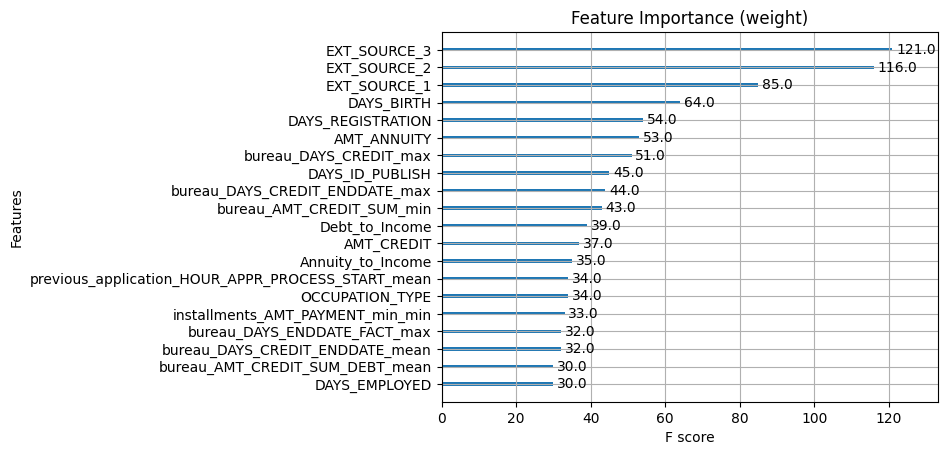

In [18]:
plt.figure(figsize=(10, 6))
xgb.plot_importance(clf_xgb, max_num_features=20, importance_type='weight')
plt.title('Feature Importance (weight)')
plt.show()

In [19]:
# Get feature weights using get_booster()
booster = clf_xgb.get_booster()
importance_type = 'weight'
scores = booster.get_score(importance_type=importance_type)

# Get all feature names from your training data
all_features = X_with_features.columns.tolist()

# Find features that were never used (not in scores dictionary)
unused_features = [feature for feature in all_features if feature not in scores]

print(f"Number of unused features: {len(unused_features)}")
print("\nFeatures never used in any tree splits:")
display(pd.DataFrame(unused_features, columns=['Unused Features']))

# Optional: Calculate percentage of unused features
percent_unused = (len(unused_features) / len(all_features)) * 100
print(f"\nPercentage of features unused: {percent_unused:.2f}%")

# Optional: Get the actual weights for used features
weights_df = pd.DataFrame([
    {'Feature': feature, 'Weight': weight}
    for feature, weight in scores.items()
]).sort_values('Weight')

print("\nFeature weights (number of times used in trees):")
display(weights_df)

Number of unused features: 654

Features never used in any tree splits:


,Unused Features
0,FLAG_OWN_REALTY
1,FLAG_MOBIL
2,FLAG_EMP_PHONE
3,FLAG_CONT_MOBILE
4,LIVE_CITY_NOT_WORK_CITY
...,...
649,pos_cash_SK_DPD_DEF_count_min
650,pos_cash_SK_DPD_DEF_count_max
651,pos_cash_SK_DPD_DEF_count_count
652,SK_ID_PREV_count



Percentage of features unused: 52.19%

Feature weights (number of times used in trees):


,Feature,Weight
0,EMERGENCYSTATE_MODE,1.0
419,credit_card_SK_DPD_sum_mean,1.0
417,credit_card_NAME_CONTRACT_STATUS_sum_sum,1.0
415,credit_card_NAME_CONTRACT_STATUS_mean_min,1.0
281,previous_application_NAME_YIELD_GROUP_min,1.0
...,...,...
24,DAYS_REGISTRATION,54.0
22,DAYS_BIRTH,64.0
39,EXT_SOURCE_1,85.0
40,EXT_SOURCE_2,116.0


Weights arrived at a very similar conclusion.

**Hyperparameter Tuning**

In [20]:
study_file = os.path.join(
    hyperparameters_folder, "optuna_study_new_features.pkl")
os.makedirs(hyperparameters_folder, exist_ok=True)

def objective(trial):
    params = {
        'objective': 'binary:logistic',
        'eval_metric': 'auc',
        'random_state': 42,
        'scale_pos_weight': (y_train == 0).sum() / (y_train == 1).sum(),
        'learning_rate': trial.suggest_float('learning_rate', 0.01, 0.3),
        'max_depth': trial.suggest_int('max_depth', 3, 20),
        'min_child_weight': trial.suggest_float('min_child_weight', 1, 10),
        'subsample': trial.suggest_float('subsample', 0.5, 1.0),
        'colsample_bytree': trial.suggest_float('colsample_bytree', 0.5, 1.0),
        'gamma': trial.suggest_float('gamma', 0, 5)
    }

    X_sparse = csr_matrix(X_with_features)
    dtrain = xgb.DMatrix(X_sparse, label=y_train)

    cv_results = xgb.cv(
        params=params,
        dtrain=dtrain,
        num_boost_round=300,
        nfold=3,
        early_stopping_rounds=10,
        verbose_eval=False
    )

    return cv_results['test-auc-mean'].max()


if os.path.exists(study_file):
    try:
        with open(study_file, "rb") as f:
            study = pkl.load(f)
        print(f"Loaded existing study from: {study_file}")
    except (pkl.UnpicklingError, EOFError, FileNotFoundError) as e:
        print(f"Failed to load study from {study_file}: {e}")
        study = None
else:
    study = None

if study is None:
    print("No valid study found. Creating a new study...")
    study = optuna.create_study(direction='maximize')
    study.optimize(objective, n_trials=20)

    with open(study_file, "wb") as f:
        pkl.dump(study, f)
    print(f"New study saved to: {study_file}")

if study:
    print("Best Parameters:", study.best_params)
    print("Best ROC AUC:", study.best_value)

Loaded existing study from: ../hyperparameters/optuna_study_new_features.pkl
Best Parameters: {'learning_rate': 0.1184806168378987, 'max_depth': 3, 'min_child_weight': 2.629482595667854, 'subsample': 0.7235769620923677, 'colsample_bytree': 0.5948119526050054, 'gamma': 0.12815402361076655}
Best ROC AUC: 0.769584795744398


Best ROC AUC score with new features is slightly lower than baseline. Try
tuning again by adjusting more refined parameter intervals, with more trials
and boost
rounds.<br>
1. learning_rate:
Current best range is around 0.1–0.15. Narrow this range for finer tuning
2. max_depth:
Smaller tree depths worked best. Focus on max_depth values of 2–5
3. min_child_weight:
Promising values are between 1–3.
4. subsample and colsample_bytree:
Stable ranges are around 0.6–0.8
5. gamma:
Lower gamma values (<1) performed well.

In [21]:
study_file = os.path.join(
    hyperparameters_folder, "optuna_study_new_features_1.pkl")
os.makedirs(hyperparameters_folder, exist_ok=True)

def objective(trial):
    params = {
        'objective': 'binary:logistic',
        'eval_metric': 'auc',
        'random_state': 42,
        'scale_pos_weight': (y_train == 0).sum() / (y_train == 1).sum(),
        'learning_rate': trial.suggest_float('learning_rate', 0.1, 0.15),
        'max_depth': trial.suggest_int('max_depth', 2, 5),
        'min_child_weight': trial.suggest_float('min_child_weight', 1, 3),
        'subsample': trial.suggest_float('subsample', 0.6, 0.8),
        'colsample_bytree': trial.suggest_float('colsample_bytree', 0.6, 0.8),
        'gamma': trial.suggest_float('gamma', 0, 0.5)
    }

    # Cross-validation with early stopping
    X_sparse = csr_matrix(X_with_features)
    dtrain = xgb.DMatrix(X_sparse, label=y_train)
    cv_results = xgb.cv(
        params=params,
        dtrain=dtrain,
        num_boost_round=500,
        nfold=3,
        early_stopping_rounds=15,
        verbose_eval=False
    )

    return cv_results['test-auc-mean'].max()

if os.path.exists(study_file):
    try:
        with open(study_file, "rb") as f:
            study = pkl.load(f)
        print(f"Loaded existing study from: {study_file}")
    except (pkl.UnpicklingError, EOFError, FileNotFoundError) as e:
        print(f"Failed to load study from {study_file}: {e}")
        study = None
else:
    study = None

if study is None:
    print("No valid study found. Creating a new study...")
    study = optuna.create_study(direction='maximize')
    study.optimize(objective, n_trials=50)

    with open(study_file, "wb") as f:
        pkl.dump(study, f)
    print(f"New study saved to: {study_file}")

if study:
    print("Best Parameters:", study.best_params)
    print("Best ROC AUC:", study.best_value)

Loaded existing study from: ../hyperparameters/optuna_study_new_features_1.pkl
Best Parameters: {'learning_rate': 0.10716979756820895, 'max_depth': 2, 'min_child_weight': 1.2010031959991356, 'subsample': 0.7739077267649818, 'colsample_bytree': 0.6481981519323131, 'gamma': 0.11399325055835141}
Best ROC AUC: 0.7729065084261832


This result is better, slightly higher than the dataset before adding new
features. It is again, a 2-3% increase.

## 6.3. Even more new features

In [27]:
X_preprocessed = preprocessor_encode.fit_transform(X_train, y_train)
X_preprocessed_df = pd.DataFrame(
    X_preprocessed,
    columns=preprocessor_encode.get_feature_names_out()
)

feature_creator = FeatureCreation2()
X_with_features = feature_creator.fit_transform(X_preprocessed_df)

dtrain = xgb.DMatrix(X_with_features, label=y_train)

params = {
    'objective': 'binary:logistic',
    'eval_metric': 'auc',
    'scale_pos_weight': (y_train == 0).sum() / (y_train == 1).sum(),
    'random_state': 42
}

cv_results = xgb.cv(
    params=params,
    dtrain=dtrain,
    num_boost_round=1000,
    nfold=5,
    early_stopping_rounds=10,
    verbose_eval=True,
    metrics='auc'
)

print(f"Best iteration: {cv_results.shape[0]}")

[0]	train-auc:0.75582+0.00196	test-auc:0.71597+0.00444
[1]	train-auc:0.77410+0.00164	test-auc:0.72693+0.00597
[2]	train-auc:0.78537+0.00218	test-auc:0.73207+0.00476
[3]	train-auc:0.79436+0.00092	test-auc:0.73540+0.00514
[4]	train-auc:0.80229+0.00044	test-auc:0.73853+0.00559
[5]	train-auc:0.80954+0.00048	test-auc:0.74072+0.00492
[6]	train-auc:0.81752+0.00085	test-auc:0.74230+0.00510
[7]	train-auc:0.82507+0.00070	test-auc:0.74472+0.00578
[8]	train-auc:0.83166+0.00144	test-auc:0.74619+0.00622
[9]	train-auc:0.83695+0.00090	test-auc:0.74722+0.00626
[10]	train-auc:0.84193+0.00131	test-auc:0.74833+0.00612
[11]	train-auc:0.84733+0.00198	test-auc:0.74901+0.00618
[12]	train-auc:0.85278+0.00192	test-auc:0.74979+0.00695
[13]	train-auc:0.85713+0.00203	test-auc:0.75066+0.00689
[14]	train-auc:0.86106+0.00252	test-auc:0.75085+0.00650
[15]	train-auc:0.86521+0.00305	test-auc:0.75125+0.00624
[16]	train-auc:0.86946+0.00268	test-auc:0.75150+0.00598
[17]	train-auc:0.87271+0.00302	test-auc:0.75176+0.00603
[1

This is the best AUC score we have reached so far. Let's try hyperparameter
tuning with the intervals used before.

**Hyperparameter Tuning**

In [23]:
study_file = os.path.join(
    hyperparameters_folder, "optuna_study_new_features_2.pkl")
os.makedirs(hyperparameters_folder, exist_ok=True)

def objective(trial):
    params = {
        'objective': 'binary:logistic',
        'eval_metric': 'auc',
        'random_state': 42,
        'scale_pos_weight': (y_train == 0).sum() / (y_train == 1).sum(),
        'learning_rate': trial.suggest_float('learning_rate', 0.1, 0.15),
        'max_depth': trial.suggest_int('max_depth', 2, 5),
        'min_child_weight': trial.suggest_float('min_child_weight', 1, 3),
        'subsample': trial.suggest_float('subsample', 0.6, 0.8),
        'colsample_bytree': trial.suggest_float('colsample_bytree', 0.6, 0.8),
        'gamma': trial.suggest_float('gamma', 0, 0.5)
    }

    # Cross-validation with early stopping
    X_sparse = csr_matrix(X_with_features)
    dtrain = xgb.DMatrix(X_sparse, label=y_train)
    cv_results = xgb.cv(
        params=params,
        dtrain=dtrain,
        num_boost_round=500,
        nfold=3,
        early_stopping_rounds=15,
        verbose_eval=False
    )

    return cv_results['test-auc-mean'].max()

if os.path.exists(study_file):
    try:
        with open(study_file, "rb") as f:
            study = pkl.load(f)
        print(f"Loaded existing study from: {study_file}")
    except (pkl.UnpicklingError, EOFError, FileNotFoundError) as e:
        print(f"Failed to load study from {study_file}: {e}")
        study = None
else:
    study = None

if study is None:
    print("No valid study found. Creating a new study...")
    study = optuna.create_study(direction='maximize')
    study.optimize(objective, n_trials=50)

    with open(study_file, "wb") as f:
        pkl.dump(study, f)
    print(f"New study saved to: {study_file}")

if study:
    print("Best Parameters:", study.best_params)
    print("Best ROC AUC:", study.best_value)

[I 2024-12-27 23:52:10,037] A new study created in memory with name: no-name-d58f2dd2-50a1-4784-b342-a3a59189a4e9


No valid study found. Creating a new study...


[I 2024-12-27 23:52:35,711] Trial 0 finished with value: 0.7718438355853486 and parameters: {'learning_rate': 0.11636603610288891, 'max_depth': 2, 'min_child_weight': 2.3960117164881147, 'subsample': 0.6088155599032404, 'colsample_bytree': 0.6994445319519429, 'gamma': 0.2545892415881835}. Best is trial 0 with value: 0.7718438355853486.
[I 2024-12-27 23:52:51,937] Trial 1 finished with value: 0.7683845023633312 and parameters: {'learning_rate': 0.11133028431236541, 'max_depth': 4, 'min_child_weight': 1.8430634389399214, 'subsample': 0.7259567209440547, 'colsample_bytree': 0.7031347164269346, 'gamma': 0.15065159356298108}. Best is trial 0 with value: 0.7718438355853486.
[I 2024-12-27 23:53:21,484] Trial 2 finished with value: 0.7715752535061263 and parameters: {'learning_rate': 0.12497320831440473, 'max_depth': 2, 'min_child_weight': 1.4258108815579391, 'subsample': 0.6073766902100992, 'colsample_bytree': 0.7944037095076664, 'gamma': 0.4507993900590566}. Best is trial 0 with value: 0.771

New study saved to: ../hyperparameters/optuna_study_new_features_2.pkl
Best Parameters: {'learning_rate': 0.11823213989877185, 'max_depth': 2, 'min_child_weight': 1.674798310390052, 'subsample': 0.7202586084244631, 'colsample_bytree': 0.780372154365198, 'gamma': 0.030406699635051937}
Best ROC AUC: 0.7734984590008444


All models after hyperparameter tuning have similar AUC ROC scores, but this
 is the best score yet. The new features will be kept.

# Improvements

1. Feature creation only focused on existing features from 'Application',
the other tables are underutilised.